<a href="https://colab.research.google.com/github/Thiraput01/My_ML_learning/blob/main/LSTM/Apple_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas_datareader as web
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import yfinance as yf

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 1) Retrive data

In [6]:
df = yf.download('AAPL', start='2015-01-01', end='2023-01-01')
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.631363,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.818405,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.865593,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,128.402313,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,128.719345,77034200


In [7]:
df.shape

(2014, 6)

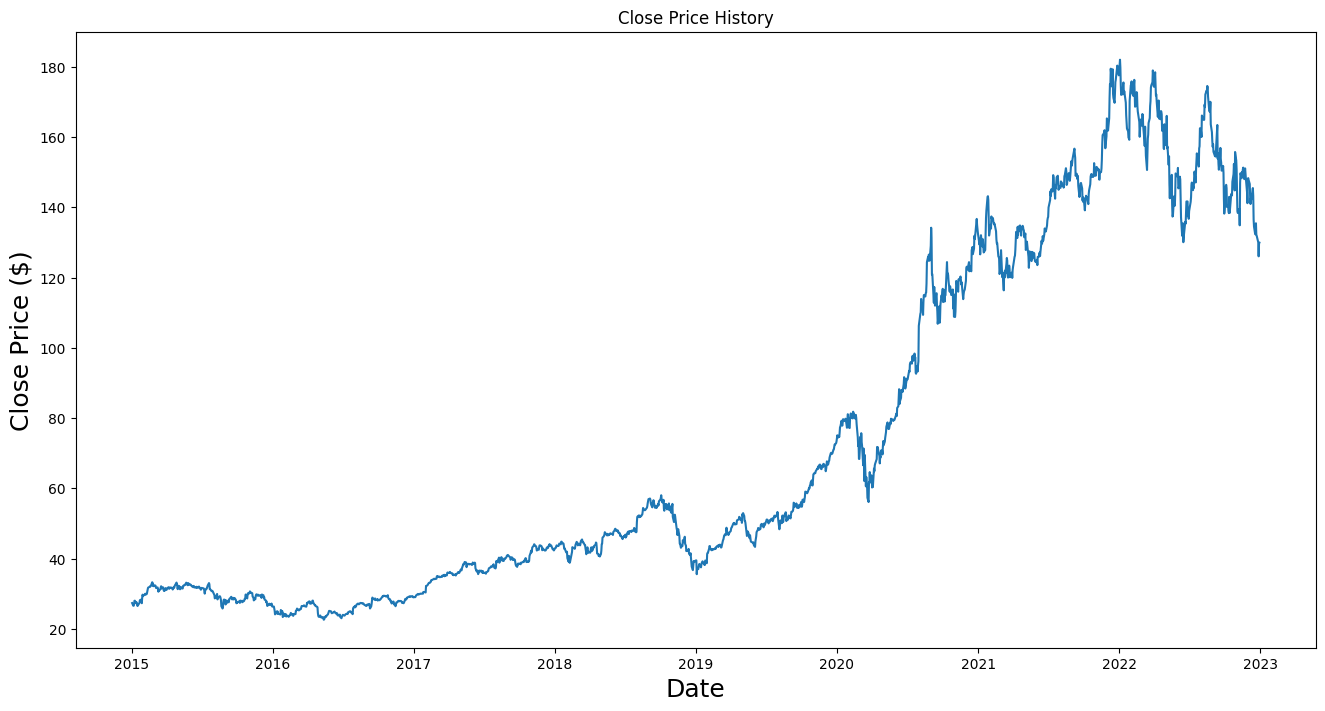

In [9]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.show()

In [12]:
data = df['Close']
data

,Close
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001


In [16]:
data.head()

,Close
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500


In [20]:
df = data.to_frame(name='Close')
df

,Close
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001


In [22]:
import pandas as pd
from copy import deepcopy as dc

def prep_for_lstm(df, n_steps):
    df = dc(df)  # Deep copy to avoid modifying the original dataframe


    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

look_back = 7
shifted_data = prep_for_lstm(df, look_back)
shifted_data


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2015-01-13,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,26.562500,27.332500
2015-01-14,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,26.562500
2015-01-15,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001
2015-01-16,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500
2015-01-20,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500
...,...,...,...,...,...,...,...,...
2022-12-23,131.860001,132.229996,135.449997,132.300003,132.369995,134.509995,136.500000,143.210007
2022-12-27,130.029999,131.860001,132.229996,135.449997,132.300003,132.369995,134.509995,136.500000
2022-12-28,126.040001,130.029999,131.860001,132.229996,135.449997,132.300003,132.369995,134.509995


In [27]:
df_to_np = shifted_data.to_numpy()
df_to_np.shape
# 2007 rows of 1 + 7 cols (out + 7 in)

(2007, 8)

In [28]:
df_to_np[:3]

array([[27.55500031, 27.3125    , 28.00250053, 27.97249985, 26.9375    ,
        26.56500053, 26.5625    , 27.33250046],
       [27.45000076, 27.55500031, 27.3125    , 28.00250053, 27.97249985,
        26.9375    , 26.56500053, 26.5625    ],
       [26.70499992, 27.45000076, 27.55500031, 27.3125    , 28.00250053,
        27.97249985, 26.9375    , 26.56500053]])

In [30]:
# scale the data
scaler = MinMaxScaler()
df_to_np = scaler.fit_transform(df_to_np)

df_to_np

array([[0.03117454, 0.02965345, 0.03398151, ..., 0.02496473, 0.02494904,
        0.0297789 ],
       [0.03051593, 0.03117454, 0.02965345, ..., 0.02730125, 0.02496473,
        0.02494904],
       [0.02584288, 0.03051593, 0.03117454, ..., 0.03379333, 0.02730125,
        0.02496473],
       ...,
       [0.64892586, 0.67395329, 0.68543205, ..., 0.68819198, 0.68863101,
        0.70205425],
       [0.67131883, 0.64892586, 0.67395329, ..., 0.70795045, 0.68819198,
        0.68863101],
       [0.67332599, 0.67131883, 0.64892586, ..., 0.68775286, 0.70795045,
        0.68819198]])

In [32]:
X = df_to_np[:, 1:]
y = df_to_np[:, 0]
X[:3], y[:3]

(array([[0.02965345, 0.03398151, 0.03379333, 0.02730125, 0.02496473,
         0.02494904, 0.0297789 ],
        [0.03117454, 0.02965345, 0.03398151, 0.03379333, 0.02730125,
         0.02496473, 0.02494904],
        [0.03051593, 0.03117454, 0.02965345, 0.03398151, 0.03379333,
         0.02730125, 0.02496473]]),
 array([0.03117454, 0.03051593, 0.02584288]))

In [34]:
X = dc(np.flip(X, axis=1))
X[:3]

array([[0.02965345, 0.03398151, 0.03379333, 0.02730125, 0.02496473,
        0.02494904, 0.0297789 ],
       [0.03117454, 0.02965345, 0.03398151, 0.03379333, 0.02730125,
        0.02496473, 0.02494904],
       [0.03051593, 0.03117454, 0.02965345, 0.03398151, 0.03379333,
        0.02730125, 0.02496473]])

In [38]:
# 80% train, 10% dev, 10% test
train_split_idx = int(len(X)*0.8)
val_split_idx = int(len(X)*0.1)
train_split_idx, val_split_idx

(1605, 200)

In [46]:
X_train = X[:train_split_idx]
y_train = y[:train_split_idx]

X_val = X[train_split_idx:train_split_idx+val_split_idx]
y_val = y[train_split_idx:train_split_idx+val_split_idx]

X_test = X[train_split_idx+val_split_idx:]
y_test = y[train_split_idx+val_split_idx:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1605, 7), (1605,), (200, 7), (200,), (202, 7), (202,))

In [47]:
X_train = X_train.reshape((-1, look_back, 1))
X_val = X_val.reshape((-1, look_back, 1))
X_test = X_test.reshape((-1, look_back, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1605, 7, 1), (1605, 1), (200, 7, 1), (200, 1), (202, 7, 1), (202, 1))

In [50]:
X_train = torch.tensor(X_train).float().to(device)
X_val = torch.tensor(X_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)

y_train = torch.tensor(y_train).float().to(device)
y_val = torch.tensor(y_val).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

X_train.shape

<ipython-input-50-24047aa43f2f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float().to(device)
<ipython-input-50-24047aa43f2f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).float().to(device)
<ipython-input-50-24047aa43f2f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float().to(device)
<ipython-input-50-24047aa43f2f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

torch.Size([1605, 7, 1])

# DataLoader

In [51]:
class StockData(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_ds = StockData(X_train, y_train)
val_ds = StockData(X_val, y_val)
test_ds = StockData(X_test, y_test)

In [52]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
len(train_loader), len(val_loader), len(test_loader)

(101, 13, 13)



> Current Dimension
*   X: 16 x 7 x 1 (batch x sequence x features)
*   Y: 16 x 1 (batch x sequence x output)





# Init model

In [66]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)


  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(input_size=1, hidden_size=4, num_layers=1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# Train / Val

In [73]:
learning_rate = 0.001
epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [74]:
def train_one_epoch():
  print(f'Epoch: {epoch+1}')
  running_loss = 0.0

  for batch_idx, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if (batch_idx+1) % 10 == 0:
      avg_loss = running_loss / 10
      train_losses.append(avg_loss)
      print(f'Batch: {batch_idx+1}, Loss: {avg_loss:.3f}')
      running_loss = 0.0
print()

In [75]:
def val_one_epoch():
    model.train(False)
    running_loss = 0.0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            running_loss += loss.item()

    avg_val_loss = running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Val loss: {avg_val_loss:.3f}')
    print('****************************')
    print()

In [76]:
train_losses = []
val_losses = []
learning_rates = []

for epoch in range(epochs):
  train_one_epoch()
  val_one_epoch()

Epoch: 1
Batch: 10, Loss: 0.169
Batch: 20, Loss: 0.184
Batch: 30, Loss: 0.148
Batch: 40, Loss: 0.113
Batch: 50, Loss: 0.118
Batch: 60, Loss: 0.091
Batch: 70, Loss: 0.074
Batch: 80, Loss: 0.078
Batch: 90, Loss: 0.058
Batch: 100, Loss: 0.075
Val loss: 0.648
****************************

Epoch: 2
Batch: 10, Loss: 0.060
Batch: 20, Loss: 0.053
Batch: 30, Loss: 0.038
Batch: 40, Loss: 0.040
Batch: 50, Loss: 0.044
Batch: 60, Loss: 0.036
Batch: 70, Loss: 0.045
Batch: 80, Loss: 0.038
Batch: 90, Loss: 0.039
Batch: 100, Loss: 0.045
Val loss: 0.414
****************************

Epoch: 3
Batch: 10, Loss: 0.044
Batch: 20, Loss: 0.039
Batch: 30, Loss: 0.034
Batch: 40, Loss: 0.038
Batch: 50, Loss: 0.035
Batch: 60, Loss: 0.039
Batch: 70, Loss: 0.030
Batch: 80, Loss: 0.030
Batch: 90, Loss: 0.036
Batch: 100, Loss: 0.033
Val loss: 0.350
****************************

Epoch: 4
Batch: 10, Loss: 0.033
Batch: 20, Loss: 0.031
Batch: 30, Loss: 0.035
Batch: 40, Loss: 0.030
Batch: 50, Loss: 0.027
Batch: 60, Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

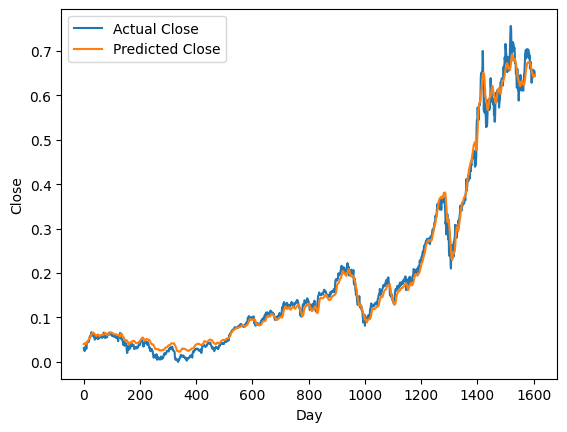

In [77]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show



> Scale data back



In [81]:
predicted[:4]

array([[0.04011425],
       [0.04012954],
       [0.04107213],
       [0.04198329]], dtype=float32)

In [78]:
train_pred = predicted.flatten()

dummies = np.zeros( (X_train.shape[0], look_back+1) )
dummies[:, 0] = train_pred

dummies = scaler.inverse_transform(dummies)

train_pred = dc(dummies[:, 0])
train_pred

array([-0.91977149, -0.91974092, -0.91785574, ...,  0.29099095,
        0.28948867,  0.29016662])

In [79]:
dummies = np.zeros( (X_train.shape[0], look_back+1) )
dummies[:, 0] = y_train.flatten()

dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-0.93765092, -0.93896814, -0.94831424, ...,  0.30864048,
        0.3080132 ,  0.28831744])

<function matplotlib.pyplot.show(close=None, block=None)>

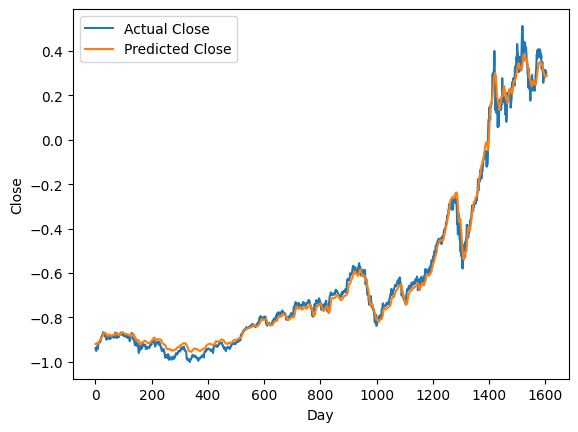

In [80]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show

Scaled Data:
[[0.66390924 0.44231756]
 [0.81746404 0.60441424]
 [0.31234637 0.        ]
 [1.         0.76645466]
 [0.25256456 0.85643234]
 [0.51866061 1.        ]
 [0.96890627 0.71604256]
 [0.65752021 0.08595841]
 [0.98550619 0.92487395]
 [0.         0.77928249]]
Inverse Transformed Data:
[[0.23177085 0.04273996]
 [0.31121606 0.04273996]
 [0.39066127 0.04273996]
 [0.47010649 0.04273996]]
